
# Intro to Machine Learning Project — Megaline Plan Recommendation

**Author:** Bilal R  
**Date:** 2025-09-04

## Project Brief
Mobile carrier **Megaline** wants a model that recommends one of the new plans — **Smart** or **Ultra** — based on subscribers' monthly behavior.

**Goal:** Build a classifier to predict `is_ultra` (Ultra=1, Smart=0) with **accuracy ≥ 0.75** on the held-out test set.

**Dataset path:** `datasets/users_behavior.csv`

**Features:**
- `calls` — number of calls
- `minutes` — total call duration (minutes)
- `messages` — number of SMS
- `mb_used` — internet traffic (MB)
- `is_ultra` — target (Ultra=1, Smart=0)

---

### Project Structure
1. Load & inspect data (EDA lite)
2. Split into **train (60%)**, **validation (20%)**, **test (20%)** — stratified
3. Train multiple models & tune hyperparameters
4. Select best model by **validation accuracy**
5. Retrain best model on **train+valid** and evaluate on **test**
6. **Sanity check** (label shuffle / dummy baseline)
7. Conclusions


In [1]:

# === Imports ===
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt

RANDOM_STATE = 12345  # fixed seed for reproducibility
DATA_PATH = 'users_behavior.csv'  # update if needed


In [2]:
import os
print(os.listdir())

['Megaline_IntroML_Project.ipynb', '.ipynb_checkpoints', 'users_behavior.csv']


## 1) Load & Inspect Data

In [3]:

# Load
df = pd.read_csv(DATA_PATH)

# Peek
display(df.head())
print("\nShape:", df.shape)
print("\nInfo:")
print(df.info())

# Summary statistics
display(df.describe())

# Missing values
print("\nMissing values per column:")
print(df.isna().sum())

# Target balance
print("\nTarget distribution (is_ultra):")
print(df['is_ultra'].value_counts())
print("\nTarget distribution (normalized):")
print(df['is_ultra'].value_counts(normalize=True).round(3))


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0



Shape: (3214, 5)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB
None


,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000



Missing values per column:
calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

Target distribution (is_ultra):
0    2229
1     985
Name: is_ultra, dtype: int64

Target distribution (normalized):
0    0.694
1    0.306
Name: is_ultra, dtype: float64


## 2) Split Data (Train/Validation/Test — 60/20/20, stratified)

In [4]:

# Features & target
FEATURES = ['calls', 'minutes', 'messages', 'mb_used']
TARGET = 'is_ultra'

X = df[FEATURES].copy()
y = df[TARGET].copy()

# First split: train vs temp (train=60%, temp=40%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=RANDOM_STATE, stratify=y
)

# Second split: temp -> validation/test (each 20% of original)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp
)

print("Shapes:")
print("  X_train:", X_train.shape, "| y_train:", y_train.shape)
print("  X_valid:", X_valid.shape, "| y_valid:", y_valid.shape)
print("  X_test :", X_test.shape,  "| y_test :", y_test.shape)

# Check class balance per split (normalized)
def balance(series, name):
    print(f"\n{name} target distribution:")
    print(series.value_counts(normalize=True).round(3))

balance(y_train, "Train")
balance(y_valid, "Valid")
balance(y_test, "Test")


Shapes:
  X_train: (1928, 4) | y_train: (1928,)
  X_valid: (643, 4) | y_valid: (643,)
  X_test : (643, 4) | y_test : (643,)

Train target distribution:
0    0.693
1    0.307
Name: is_ultra, dtype: float64

Valid target distribution:
0    0.694
1    0.306
Name: is_ultra, dtype: float64

Test target distribution:
0    0.694
1    0.306
Name: is_ultra, dtype: float64


## 3) Baseline — Dummy Classifier (Most Frequent)

In [5]:

dummy = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)
baseline_valid_acc = accuracy_score(y_valid, dummy.predict(X_valid))
print(f"Baseline (most_frequent) validation accuracy: {baseline_valid_acc:.3f}")


Baseline (most_frequent) validation accuracy: 0.694


## 4) Model Training & Hyperparameter Tuning

In [6]:

results = []  # we'll collect (model_name, params, valid_acc)

def log_result(model_name, params, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    results.append({
        'model': model_name,
        'params': params,
        'valid_accuracy': acc
    })
    print(f"{model_name} {params} -> val_acc={acc:.4f}")


### 4.1 Logistic Regression (with StandardScaler)

In [7]:

Cs = [0.1, 1.0, 10.0]
for C in Cs:
    pipe_lr = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(C=C, max_iter=2000, random_state=RANDOM_STATE))
    ])
    pipe_lr.fit(X_train, y_train)
    y_pred_valid = pipe_lr.predict(X_valid)
    log_result('LogisticRegression', {'C': C}, y_valid, y_pred_valid)


LogisticRegression {'C': 0.1} -> val_acc=0.7387
LogisticRegression {'C': 1.0} -> val_acc=0.7387
LogisticRegression {'C': 10.0} -> val_acc=0.7387


### 4.2 Decision Tree

In [8]:

best_dt = (None, -1, None)  # (model, best_acc, best_params)
for max_depth in range(2, 21):
    for min_samples_leaf in [1, 2, 3, 5]:
        dt = DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            random_state=RANDOM_STATE
        )
        dt.fit(X_train, y_train)
        y_pred_valid = dt.predict(X_valid)
        acc = accuracy_score(y_valid, y_pred_valid)
        log_result('DecisionTree', {'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf}, y_valid, y_pred_valid)
        if acc > best_dt[1]:
            best_dt = (dt, acc, {'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf})

print("\nBest DecisionTree on validation:")
print(best_dt[2], "->", f"{best_dt[1]:.4f}")


DecisionTree {'max_depth': 2, 'min_samples_leaf': 1} -> val_acc=0.7729
DecisionTree {'max_depth': 2, 'min_samples_leaf': 2} -> val_acc=0.7729
DecisionTree {'max_depth': 2, 'min_samples_leaf': 3} -> val_acc=0.7729
DecisionTree {'max_depth': 2, 'min_samples_leaf': 5} -> val_acc=0.7729
DecisionTree {'max_depth': 3, 'min_samples_leaf': 1} -> val_acc=0.7776
DecisionTree {'max_depth': 3, 'min_samples_leaf': 2} -> val_acc=0.7776
DecisionTree {'max_depth': 3, 'min_samples_leaf': 3} -> val_acc=0.7776
DecisionTree {'max_depth': 3, 'min_samples_leaf': 5} -> val_acc=0.7776
DecisionTree {'max_depth': 4, 'min_samples_leaf': 1} -> val_acc=0.7543
DecisionTree {'max_depth': 4, 'min_samples_leaf': 2} -> val_acc=0.7543
DecisionTree {'max_depth': 4, 'min_samples_leaf': 3} -> val_acc=0.7558
DecisionTree {'max_depth': 4, 'min_samples_leaf': 5} -> val_acc=0.7558
DecisionTree {'max_depth': 5, 'min_samples_leaf': 1} -> val_acc=0.7854
DecisionTree {'max_depth': 5, 'min_samples_leaf': 2} -> val_acc=0.7854
Decisi

### 4.3 Random Forest

In [9]:

best_rf = (None, -1, None)  # (model, best_acc, best_params)
for n_estimators in [50, 100, 200, 300]:
    for max_depth in [None, 5, 10, 15, 20]:
        for min_samples_split in [2, 5]:
            rf = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                n_jobs=-1,
                random_state=RANDOM_STATE
            )
            rf.fit(X_train, y_train)
            y_pred_valid = rf.predict(X_valid)
            acc = accuracy_score(y_valid, y_pred_valid)
            log_result('RandomForest', {'n_estimators': n_estimators, 'max_depth': max_depth, 'min_samples_split': min_samples_split}, y_valid, y_pred_valid)
            if acc > best_rf[1]:
                best_rf = (rf, acc, {'n_estimators': n_estimators, 'max_depth': max_depth, 'min_samples_split': min_samples_split})

print("\nBest RandomForest on validation:")
print(best_rf[2], "->", f"{best_rf[1]:.4f}")


RandomForest {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 2} -> val_acc=0.8056
RandomForest {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 5} -> val_acc=0.8118
RandomForest {'n_estimators': 50, 'max_depth': 5, 'min_samples_split': 2} -> val_acc=0.8009
RandomForest {'n_estimators': 50, 'max_depth': 5, 'min_samples_split': 5} -> val_acc=0.7994
RandomForest {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 2} -> val_acc=0.8134
RandomForest {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 5} -> val_acc=0.8149
RandomForest {'n_estimators': 50, 'max_depth': 15, 'min_samples_split': 2} -> val_acc=0.8040
RandomForest {'n_estimators': 50, 'max_depth': 15, 'min_samples_split': 5} -> val_acc=0.8103
RandomForest {'n_estimators': 50, 'max_depth': 20, 'min_samples_split': 2} -> val_acc=0.7947
RandomForest {'n_estimators': 50, 'max_depth': 20, 'min_samples_split': 5} -> val_acc=0.8040
RandomForest {'n_estimators': 100, 'max_depth': None, 'min_samples_s

### 4.4 Compare Validation Results

In [10]:

df_results = pd.DataFrame(results).sort_values('valid_accuracy', ascending=False).reset_index(drop=True)
display(df_results.head(10))

best_row = df_results.iloc[0]
best_model_name = best_row['model']
best_params = best_row['params']
best_val_acc = best_row['valid_accuracy']

print(f"\nSelected best model on validation: {best_model_name} with params {best_params} (val_acc={best_val_acc:.4f})")


,model,params,valid_accuracy
0,RandomForest,"{'n_estimators': 50, 'max_depth': 10, 'min_sam...",0.814930
1,RandomForest,"{'n_estimators': 100, 'max_depth': 10, 'min_sa...",0.814930
2,RandomForest,"{'n_estimators': 100, 'max_depth': 10, 'min_sa...",0.814930
3,RandomForest,"{'n_estimators': 300, 'max_depth': 10, 'min_sa...",0.813375
4,RandomForest,"{'n_estimators': 50, 'max_depth': 10, 'min_sam...",0.813375
5,RandomForest,"{'n_estimators': 200, 'max_depth': 10, 'min_sa...",0.811820
6,RandomForest,"{'n_estimators': 200, 'max_depth': 15, 'min_sa...",0.811820
7,RandomForest,"{'n_estimators': 300, 'max_depth': 10, 'min_sa...",0.811820
8,RandomForest,"{'n_estimators': 50, 'max_depth': None, 'min_s...",0.811820
9,RandomForest,"{'n_estimators': 100, 'max_depth': 15, 'min_sa...",0.810264



Selected best model on validation: RandomForest with params {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 5} (val_acc=0.8149)


## 5) Final Training on Train+Valid & Test Evaluation


TEST accuracy (RandomForest): 0.8243

Classification report (test):
              precision    recall  f1-score   support

           0      0.828     0.942     0.881       446
           1      0.809     0.558     0.661       197

    accuracy                          0.824       643
   macro avg      0.819     0.750     0.771       643
weighted avg      0.822     0.824     0.814       643



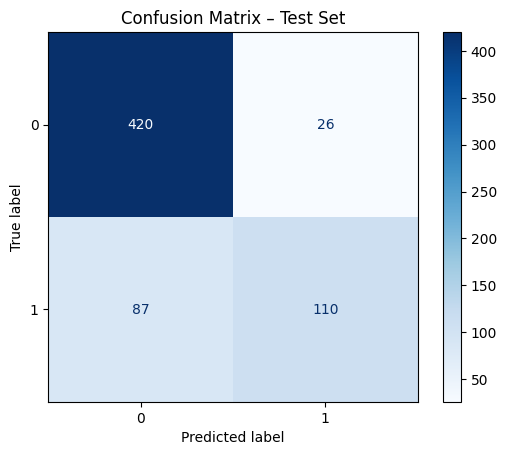

In [11]:

# Combine train + valid for final training
X_train_full = pd.concat([X_train, X_valid], axis=0)
y_train_full = pd.concat([y_train, y_valid], axis=0)

def build_best_model(name, params):
    if name == 'LogisticRegression':
        # C param in LogisticRegression
        C = params.get('C', 1.0)
        model = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('lr', LogisticRegression(C=C, max_iter=2000, random_state=RANDOM_STATE))
        ])
    elif name == 'DecisionTree':
        model = DecisionTreeClassifier(
            max_depth=params.get('max_depth'),
            min_samples_leaf=params.get('min_samples_leaf', 1),
            random_state=RANDOM_STATE
        )
    elif name == 'RandomForest':
        model = RandomForestClassifier(
            n_estimators=params.get('n_estimators', 100),
            max_depth=params.get('max_depth'),
            min_samples_split=params.get('min_samples_split', 2),
            n_jobs=-1,
            random_state=RANDOM_STATE
        )
    else:
        raise ValueError("Unknown model name")
    return model

final_model = build_best_model(best_model_name, best_params)
final_model.fit(X_train_full, y_train_full)

# Evaluate on test
y_pred_test = final_model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred_test)
print(f"\nTEST accuracy ({best_model_name}): {test_acc:.4f}")

print("\nClassification report (test):")
print(classification_report(y_test, y_pred_test, digits=3))

# Confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Test Set")
plt.show()


## 6) Sanity Check

In [12]:

# 6.1 Shuffle labels sanity check (expect ~random performance ~0.5 accuracy)
y_train_shuffled = y_train.sample(frac=1.0, random_state=RANDOM_STATE).reset_index(drop=True)
X_train_shuffled = X_train.reset_index(drop=True)

sanity_model = build_best_model(best_model_name, best_params)
sanity_model.fit(X_train_shuffled, y_train_shuffled)
y_pred_valid_sanity = sanity_model.predict(X_valid)
sanity_acc = accuracy_score(y_valid, y_pred_valid_sanity)

print(f"Sanity check — validation accuracy with SHUFFLED labels: {sanity_acc:.3f}")
print("If the model is learning real signal, this should be much closer to 0.5 than to your best validation accuracy.")


Sanity check — validation accuracy with SHUFFLED labels: 0.687
If the model is learning real signal, this should be much closer to 0.5 than to your best validation accuracy.



## 7) Conclusions

- **Best model:** _will be printed above from `df_results`_
- **Validation accuracy:** _see results table_
- **Test accuracy:** _printed above; must be ≥ 0.75_

**Notes / Findings:**
- Trees/forests often perform well on tabular data with non-linear relationships and feature interactions, which may explain better performance vs. logistic regression.  
- Stratified splits help maintain class balance across train/valid/test sets.  
- Dummy baseline (most frequent class) provides a sanity reference; your model should beat it substantially.  
- The sanity check with shuffled labels prevents overinterpreting artifacts — performance should collapse toward random (~0.5) if labels are noise.

